In [1]:
import opendatasets as od
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
def load_dataset():
    od.download("https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification")
    csv_path = "ecommerce-text-classification/ecommerceDataset.csv"
    df = pd.read_csv(csv_path)
    df = df.iloc[:, :2]
    df.columns = ["category", "description"]
    df.dropna(inplace=True)
    df["description"] = df["description"].astype(str)
    df["category"] = df["category"].astype(str)
    return df

In [7]:
df = load_dataset()

Skipping, found downloaded files in ".\ecommerce-text-classification" (use force=True to force download)


---

## phase 0: data profiling

In [9]:
# Shape and structure
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Shape: (50423, 2)

Columns: ['category', 'description']


In [11]:
df.head()

,category,description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [13]:
# Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50423 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50423 non-null  object
 1   description  50423 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [15]:
# Missing values
df.isnull().sum()

category       0
description    0
dtype: int64

In [17]:
dup_mask = df.duplicated(subset=["description"], keep=False)

print("Total duplicate rows:", dup_mask.sum())


Total duplicate rows: 36601


In [19]:
dup_counts = df["description"].value_counts()
dup_counts[dup_counts > 1].head()


Think & Grow Rich About the Author NAPOLEON HILL, born in Pound, Southwest Virginia in 1883, was a very successful American author in the area of the new thought movement—one of the earliest producers of the modern genre of personal-success literature. He is widely considered to be one of the great writers on success. The turning point in Hill’s life occurred in the year 1908 when he interviewed the industrialist Andrew Carnegie—one of the most powerful men in the world at that time, as part of an assignment—an interview which ultimately led to the publication of Think and Grow Rich, one of his best-selling books of all time. the book examines the power of personal beliefs and the role they play in personal success. Hill, who had even served as the advisor to President Franklin D. Roosevelt from 1933-36, passed away at the age of 87.                                                                                                                                                           

In [21]:
# Count number of descriptions per category
category_counts = df.groupby("category")["description"].count().reset_index()

category_counts = category_counts.rename(columns={"description": "num_descriptions"})
category_counts

,category,num_descriptions
0,Books,11820
1,Clothing & Accessories,8670
2,Electronics,10621
3,Household,19312


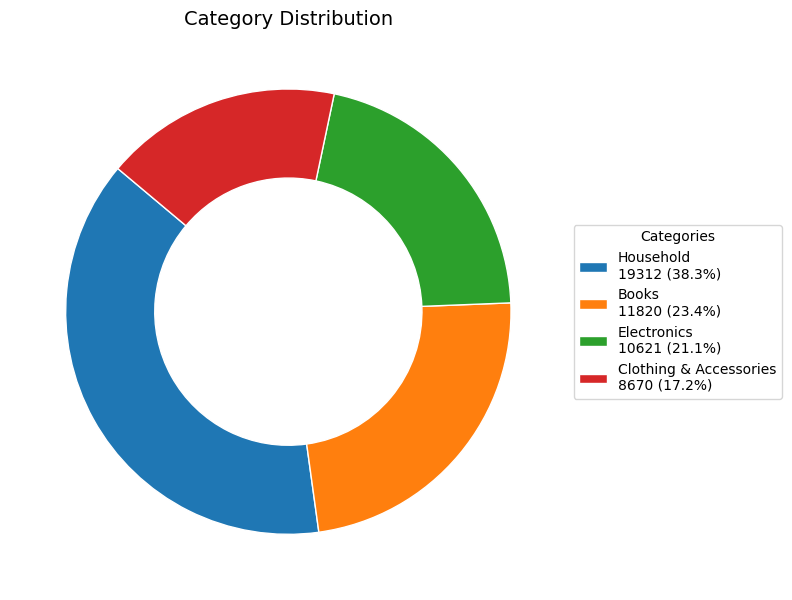

In [23]:
def plot_category_distribution(df, cat_col="category"):
    """
    Plots a donut (pizza-like) chart for category distribution with better percentages.
    """
    category_counts = df[cat_col].value_counts()
    labels = [f"{cat}\n{count} ({count/len(df)*100:.1f}%)" 
              for cat, count in zip(category_counts.index, category_counts.values)]

    fig, ax = plt.subplots(figsize=(8,8))
    wedges, texts = ax.pie(
        category_counts,
        startangle=140,
        wedgeprops=dict(width=0.4, edgecolor="w")
    )

    ax.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    ax.set_title("Category Distribution", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_category_distribution(df, cat_col="category")

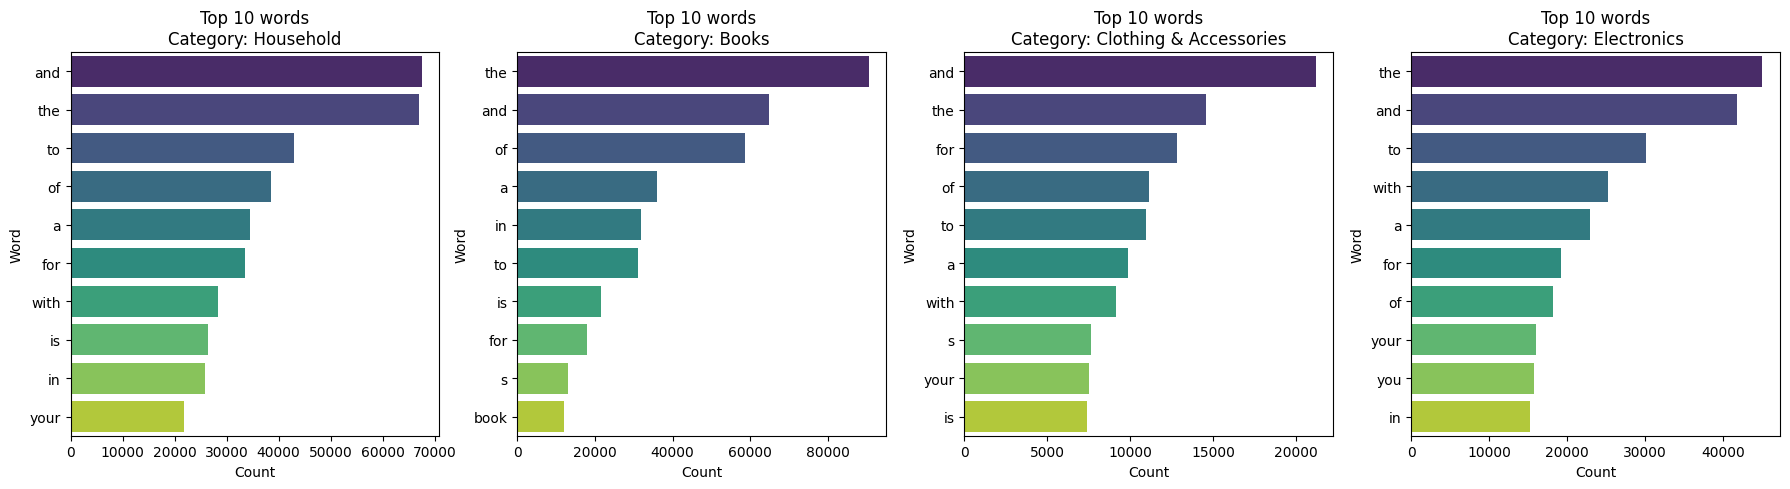

In [25]:
def plot_top_words_per_category(df, text_col="description", cat_col="category", top_n=10, max_classes=4):
    """
    Plots top-N most frequent words per category (up to max_classes categories).
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing text and categories.
    text_col : str
        Column name of text descriptions.
    cat_col : str
        Column name of categories.
    top_n : int
        Number of top words to display.
    max_classes : int
        Number of categories to plot (max).
    """
    categories = df[cat_col].unique()[:max_classes]
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 5), sharey=False)

    if len(categories) == 1:
        axes = [axes]  # make iterable if only one category

    for ax, cat in zip(axes, categories):
        # Get all text for this category
        texts = df.loc[df[cat_col] == cat, text_col].astype(str).str.lower().tolist()
        all_text = " ".join(texts)

        # Clean: keep only letters and spaces
        all_text = re.sub(r"[^a-z\s]", " ", all_text)
        tokens = all_text.split()

        # Word frequency
        freq = Counter(tokens).most_common(top_n)
        words, counts = zip(*freq) if freq else ([], [])

        sns.barplot(
            x=list(counts), 
            y=list(words), 
            hue=list(words),
            dodge=False,
            legend=False,
            palette="viridis", 
            ax=ax
        )

        ax.set_title(f"Top {top_n} words\nCategory: {cat}")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()


plot_top_words_per_category(df, text_col="description", cat_col="category", top_n=10, max_classes=4)


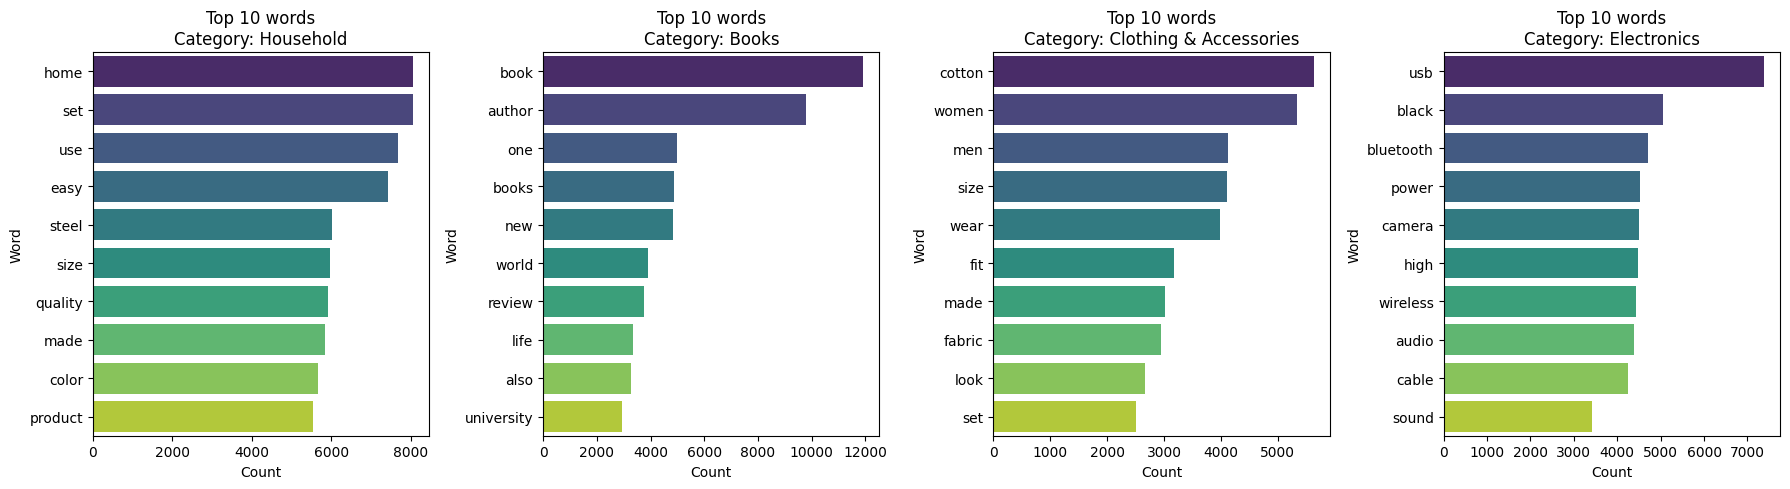

In [60]:
stop_words = set(stopwords.words("english"))

def plot_top_words_per_category_with_simple_preprocess(df, text_col="description", cat_col="category", top_n=10, max_classes=4):
    """
    Plots top-N most frequent words per category (up to max_classes categories).
    Removes basic English stopwords.
    """
    categories = df[cat_col].unique()[:max_classes]
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 5), sharey=False)

    if len(categories) == 1:
        axes = [axes]

    for ax, cat in zip(axes, categories):
        # Collect all text for this category
        texts = df.loc[df[cat_col] == cat, text_col].astype(str).str.lower().tolist()
        all_text = " ".join(texts)

        # Clean: keep only letters + spaces
        all_text = re.sub(r"[^a-z\s]", " ", all_text)
        tokens = [w for w in all_text.split() if w not in stop_words and len(w) > 2]

        # Frequency
        freq = Counter(tokens).most_common(top_n)
        words, counts = zip(*freq) if freq else ([], [])

        # Plot
        sns.barplot(
            x=list(counts), 
            y=list(words), 
            hue=list(words),
            dodge=False,
            legend=False,
            palette="viridis", 
            ax=ax
        )
        ax.set_title(f"Top {top_n} words\nCategory: {cat}")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()

plot_top_words_per_category_with_simple_preprocess(df, text_col="description", cat_col="category", top_n=10, max_classes=4)

In [88]:
def plot_length_per_category_row(df, text_col="description", cat_col="category", max_classes=4, max_words=200):
    """
    Plots words-per-description histograms per category, in one row.

    Parameters:
    - df: pandas DataFrame
    - text_col: column with text
    - cat_col: column with categories
    - max_classes: how many categories to show
    - max_words: upper limit for word count (X-axis cap)
    """
    cats = df[cat_col].astype(str).unique()[:max_classes]
    fig, axes = plt.subplots(1, len(cats), figsize=(5 * len(cats), 4), sharey=True)

    if len(cats) == 1:
        axes = [axes]

    for ax, c in zip(axes, cats):
        sub = df[df[cat_col] == c][text_col].astype(str).tolist()
        cleaned = [_simple_clean(t) for t in sub]
        wc = [len([w for w in s.split() if w not in stop_words and len(w) > 2]) for s in cleaned]

        ax.hist(wc, bins=30, color="steelblue", edgecolor="black")
        ax.set_title(f"{c}\n(words per description)", fontsize=10)
        ax.set_xlim(0, max_words)
        ax.set_xlabel("Word count")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


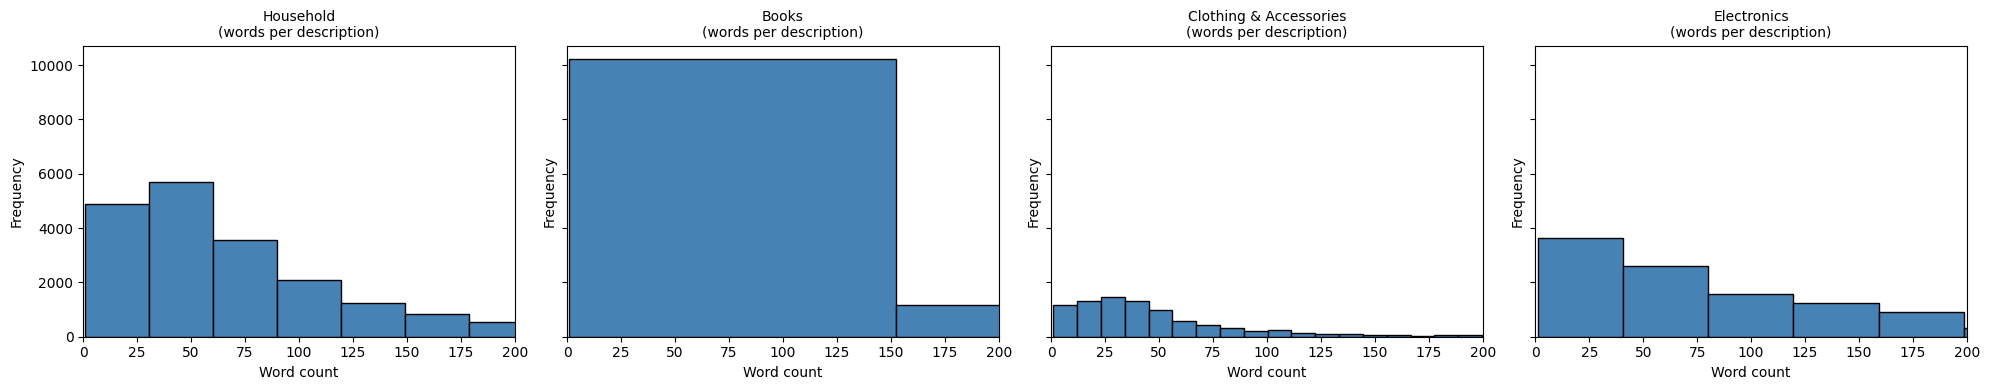

In [90]:
plot_length_per_category_row(df, text_col="description", cat_col="category", max_classes=4, max_words=200)


In [92]:
def _simple_clean(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _top_ngrams(texts, n=2, top_n=10, stop_words="english", min_df=2):
    """
    Return (terms, counts) for top n-grams from a list of texts.
    """
    if not texts:
        return [], []
    cleaned = [_simple_clean(t) for t in texts]
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stop_words, min_df=min_df)
    X = vec.fit_transform(cleaned)
    if X.shape[1] == 0:
        return [], []
    vocab = np.array(vec.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1][:top_n]
    return vocab[order].tolist(), freqs[order].tolist()

def plot_ngrams_per_category_row(
    df,
    text_col="description",
    cat_col="category",
    n=2,
    top_n=10,
    stop_words="english",
    min_df=2,
    category_order="freq",   # "freq" (most rows first) or "alpha"
    max_categories=None      # None = all
):
    """
    For each category, plot a horizontal bar chart of top-N n-grams.
    All plots are arranged in a single row.
    """
    # pick/ordering categories
    if category_order == "freq":
        cats = df[cat_col].value_counts().index.tolist()
    else:
        cats = sorted(df[cat_col].astype(str).unique())
    if max_categories is not None:
        cats = cats[:max_categories]

    k = len(cats)
    if k == 0:
        print("No categories found.")
        return

    fig, axes = plt.subplots(1, k, figsize=(max(5*k, 6), 4), sharey=False)
    if k == 1:
        axes = [axes]

    for ax, c in zip(axes, cats):
        texts = df.loc[df[cat_col] == c, text_col].astype(str).tolist()
        terms, counts = _top_ngrams(texts, n=n, top_n=top_n, stop_words=stop_words, min_df=min_df)

        if len(terms) == 0:
            ax.text(0.5, 0.5, "Not enough data", ha="center", va="center")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(str(c))
            continue

        # plot (largest at top)
        terms_plot = terms[::-1]
        counts_plot = counts[::-1]
        y = np.arange(len(terms_plot))
        ax.barh(y, counts_plot)
        ax.set_yticks(y)
        ax.set_yticklabels(terms_plot)
        ax.set_xlabel("Count")
        ax.set_title(f"{c}\nTop {top_n} {n}-grams", fontsize=10)

    plt.tight_layout()
    plt.show()


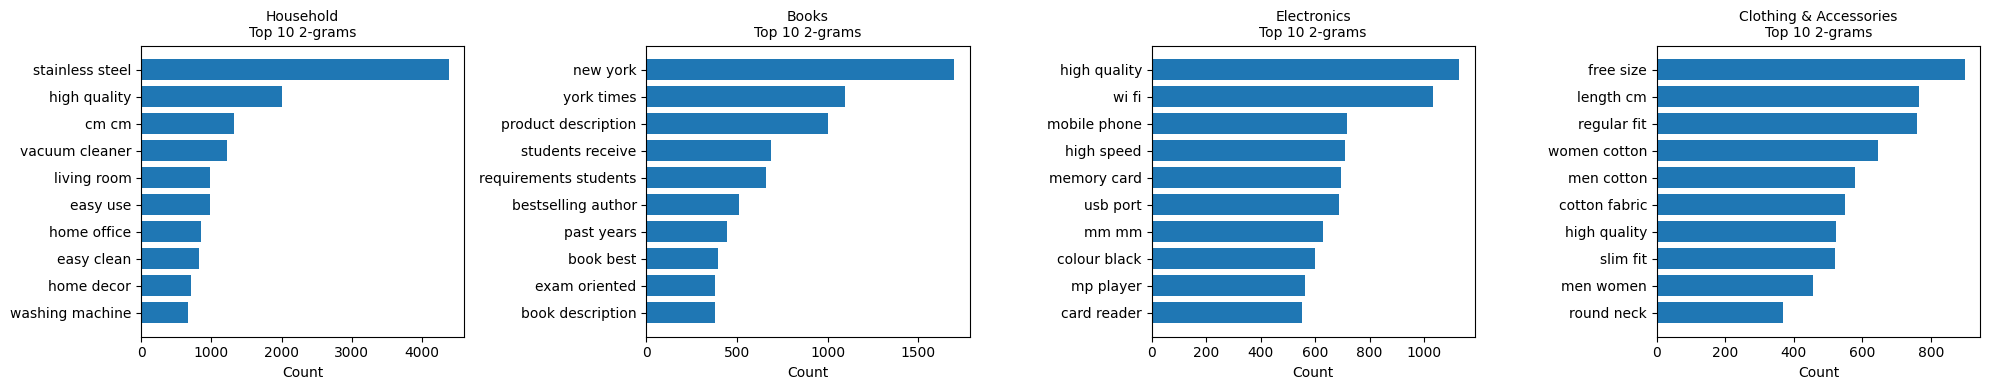

In [94]:
plot_ngrams_per_category_row(df, text_col="description", cat_col="category", n=2, top_n=10)


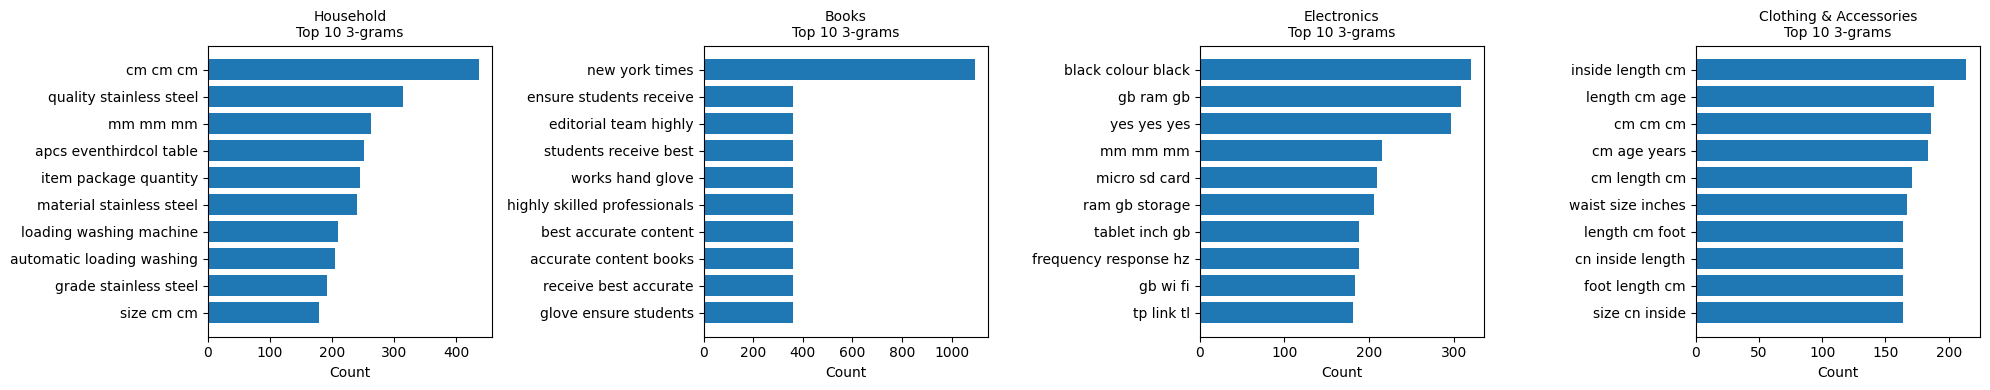

In [95]:
plot_ngrams_per_category_row(df, text_col="description", cat_col="category", n=3, top_n=10)


---

## Phase 1: data preprocessing

In [30]:
import unicodedata
from typing import List, Iterable
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import contractions


In [32]:
# Remove exact duplicate rows
df = df.drop_duplicates(subset=["description"]).reset_index(drop=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27801 entries, 0 to 27800
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     27801 non-null  object
 1   description  27801 non-null  object
dtypes: object(2)
memory usage: 434.5+ KB


In [36]:
for pkg in ["punkt", "stopwords", "wordnet", "omw-1.4", "averaged_perceptron_tagger"]:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        try:
            nltk.download(pkg, quiet=True)
        except:
            nltk.download(pkg)

EN_STOP = set(stopwords.words("english"))
EN_STOP -= {"no", "not", "nor"}

LEMM = WordNetLemmatizer()

In [125]:
from nltk import data
nltk.download('averaged_perceptron_tagger_eng')  # newer NLTK expects this

print(data.find('taggers/averaged_perceptron_tagger_eng/'))


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


C:\Users\user\AppData\Roaming\nltk_data\taggers\averaged_perceptron_tagger_eng


[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [72]:
def _to_wordnet_pos(treebank_tag: str):
    """Map NLTK POS tags to WordNet POS tags for better lemmatization."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

import re

def normalize_units_and_remove_singletons(docs):
    """
    Normalize measurements into num<unit>, 
    remove single-char junk like 'x', and collapse duplicates.
    """

    unit_patterns = {
        r"\b\d+(\.\d+)?\s*cm\b": "numcm",
        r"\b\d+(\.\d+)?\s*mm\b": "nummm",
        r"\b\d+(\.\d+)?\s*(in|inch|inches)\b": "numinch",
        r"\b\d+(\.\d+)?\s*gb\b": "numgb",
        r"\b\d+(\.\d+)?\s*mb\b": "nummb",
        r"\b\d+(\.\d+)?\s*tb\b": "numtb",
        r"\b\d+(\.\d+)?\s*hz\b": "numhz",
        r"\b\d+(\.\d+)?\s*mhz\b": "nummhz",
        r"\b\d+(\.\d+)?\s*ghz\b": "numghz",
        r"\b\d+(\.\d+)?\s*v\b": "numv",
        r"\b\d+(\.\d+)?\s*w\b": "numw",
        r"\b\d+(\.\d+)?\s*mah\b": "nummah",
    }

    cleaned = []
    for doc in docs:
        text = str(doc).lower()

        # Step 1: normalize units
        for pat, rep in unit_patterns.items():
            text = re.sub(pat, rep, text)

        # Step 2: remove single-char dimension separators (before collapse)
        text = re.sub(r"\b[x×*]\b", " ", text)

        # Step 3: collapse consecutive duplicates
        text = re.sub(r"\b(\w+)(\s+\1){1,}\b", r"\1", text)

        cleaned.append(re.sub(r"\s+", " ", text).strip())
    return cleaned


def expand_contractions(docs: Iterable[str]) -> List[str]:
    """Expand English contractions: don't -> do not, it's -> it is, etc."""
    return [contractions.fix(str(doc)) for doc in docs]

def to_lowercase(docs: Iterable[str]) -> List[str]:
    """Lowercase everything."""
    return [str(doc).lower() for doc in docs]

def remove_numbers(docs: Iterable[str]) -> List[str]:
    """Remove all digits (keeps letters and punctuation)."""
    return [re.sub(r"\d+", " ", str(doc)) for doc in docs]

def remove_punctuation(docs: Iterable[str]) -> List[str]:
    """Remove punctuation characters."""
    def _strip_punct(s):
        return "".join(ch if unicodedata.category(ch)[0] != "P" else " " for ch in s)
    return [_strip_punct(str(doc)) for doc in docs]

def remove_special_and_emojis(docs: Iterable[str]) -> List[str]:
    """
    Remove emojis and special symbols (keep letters, numbers, and spaces).
    You asked to remove emojis; this regex strips most pictographs/symbols.
    """
    emoji_re = re.compile(
        "["                        # open class
        "\U0001F300-\U0001F5FF"    # symbols & pictographs
        "\U0001F600-\U0001F64F"    # emoticons
        "\U0001F680-\U0001F6FF"    # transport & map symbols
        "\U0001F700-\U0001F77F"    # alchemical symbols
        "\U0001F780-\U0001F7FF"    # geometric shapes extended
        "\U0001F800-\U0001F8FF"    # supplemental arrows-C
        "\U0001F900-\U0001F9FF"    # supplemental symbols & pictographs
        "\U0001FA00-\U0001FA6F"    # chess, symbols & pictographs ext-A
        "\U00002700-\U000027BF"    # dingbats
        "\U00002600-\U000026FF"    # misc symbols
        "]+",
        flags=re.UNICODE
    )
    cleaned = []
    for doc in docs:
        s = emoji_re.sub(" ", str(doc))
        s = "".join(ch if (ch.isalnum() or ch.isspace()) else " " for ch in s)
        cleaned.append(s)
    return cleaned

def normalize_whitespace(docs: Iterable[str]) -> List[str]:
    """Collapse multiple spaces/tabs/newlines to a single space; strip ends."""
    return [re.sub(r"\s+", " ", str(doc)).strip() for doc in docs]

def tokenize(docs: Iterable[str]) -> List[List[str]]:
    """Tokenize into words using NLTK's word_tokenize."""
    return [word_tokenize(str(doc)) for doc in docs]

def remove_stopwords(token_lists: Iterable[List[str]], extra_stop: Iterable[str] = ()) -> List[List[str]]:
    """
    Remove stopwords while keeping negations.
    You can pass domain-specific stopwords via extra_stop.
    """
    stop_set = EN_STOP.union(set(extra_stop))
    return [[tok for tok in tokens if tok not in stop_set] for tokens in token_lists]

def lemmatize(token_lists: Iterable[List[str]]) -> List[List[str]]:
    """Lemmatize tokens with POS-aware lemmatizer (WordNet)."""
    lemmatized_docs = []
    for tokens in token_lists:
        # POS tagging expects tokens
        pos_tags = pos_tag(tokens)
        lemmas = [LEMM.lemmatize(tok, _to_wordnet_pos(pos)) for tok, pos in pos_tags]
        lemmatized_docs.append(lemmas)
    return lemmatized_docs


def preprocess_corpus(
    raw_docs: Iterable[str],
    *,
    do_lower=True,
    do_remove_numbers=True,
    do_expand_contractions=True,
    do_remove_punct=True,
    do_remove_special=True,
    do_tokenize=True,
    do_remove_stop=True,
    do_lemmatize=True,
    extra_stop: Iterable[str] = ()
):
    """
    Run the configurable pipeline and return tokenized (and lemmatized) docs.
    Each step can be toggled with flags. Returns:
      - tokens: List[List[str]]
    """
    docs = list(raw_docs)

    if do_expand_contractions:
        docs = expand_contractions(docs)
    if do_lower:
        docs = to_lowercase(docs)
    if do_remove_numbers:
        docs = remove_numbers(docs)
    if do_remove_punct:
        docs = remove_punctuation(docs)
    if do_remove_special:
        docs = remove_special_and_emojis(docs)

    docs = normalize_whitespace(docs)

    if do_tokenize:
        tokens = tokenize(docs)
    else:
        # if you skip tokenization, split on whitespace as fallback
        tokens = [d.split() for d in docs]

    if do_remove_stop:
        tokens = remove_stopwords(tokens, extra_stop=extra_stop)
    if do_lemmatize:
        tokens = lemmatize(tokens)

    # final cleanup: drop empty tokens & normalize whitespace in tokens
    tokens = [[t for t in doc if t.strip()] for doc in tokens]
    return tokens

In [74]:
raw = df["description"].astype(str).tolist()

normalized = normalize_units_and_remove_singletons(raw)

clean_tokens = preprocess_corpus(
    normalized,
    do_expand_contractions=True,
    do_lower=True,
    do_remove_numbers=True,
    do_remove_punct=True,
    do_remove_special=True,
    do_tokenize=True,
    do_remove_stop=True,
    do_lemmatize=True,
    extra_stop={"package", "item"}
)

# Peek
for i in range(3):
    print(clean_tokens[i][:30])


['saf', 'floral', 'frame', 'paint', 'wood', 'numinch', 'special', 'effect', 'uv', 'print', 'textured', 'sao', 'painting', 'make', 'synthetic', 'frame', 'uv', 'textured', 'print', 'give', 'multi', 'effect', 'attract', 'towards', 'special', 'series', 'painting', 'make', 'wall', 'beautiful']
['saf', 'uv', 'textured', 'modern', 'art', 'print', 'frame', 'paint', 'synthetic', 'numcm', 'set', 'color', 'multicolor', 'size', 'numcm', 'overview', 'beautiful', 'paint', 'involve', 'action', 'skill', 'use', 'paint', 'right', 'manner', 'hence', 'end', 'product', 'picture', 'speak']
['saf', 'flower', 'print', 'frame', 'paint', 'synthetic', 'numinch', 'uv', 'textured', 'set', 'sanfsw', 'color', 'multicolor', 'size', 'numcm', 'beautiful', 'paint', 'involve', 'action', 'skill', 'use', 'paint', 'right', 'manner', 'hence', 'end', 'product', 'picture', 'speak', 'thousand']


In [76]:
df["clean_tokens"] = clean_tokens

In [78]:
df.head()

,category,description,clean_tokens
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...","[saf, floral, frame, paint, wood, numinch, spe..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,"[saf, uv, textured, modern, art, print, frame,..."
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1...","[saf, flower, print, frame, paint, synthetic, ..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...,"[incredible, gift, india, wooden, happy, birth..."
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,"[pitaara, box, romantic, venice, canvas, paint..."


In [80]:
print(df.loc[0, "description"])


SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch (A perfect gift for your special ones).


In [82]:
print(df.loc[0, "clean_tokens"])


['saf', 'floral', 'frame', 'paint', 'wood', 'numinch', 'special', 'effect', 'uv', 'print', 'textured', 'sao', 'painting', 'make', 'synthetic', 'frame', 'uv', 'textured', 'print', 'give', 'multi', 'effect', 'attract', 'towards', 'special', 'series', 'painting', 'make', 'wall', 'beautiful', 'give', 'royal', 'touch', 'perfect', 'gift', 'special', 'one']


---

In [16]:


def compute_tfidf(corpus):
    docs = [doc.split() for doc in corpus]
    vocab = sorted(list(set([w for doc in docs for w in doc])))
    N = len(docs)
    vocab_index = {word: idx for idx, word in enumerate(vocab)}

    tf = np.zeros((N, len(vocab)))
    df = np.zeros(len(vocab))

    for doc_idx, doc in enumerate(docs):
        word_counts = {}
        for word in doc:
            word_counts[word] = word_counts.get(word, 0) + 1
        for word, count in word_counts.items():
            idx = vocab_index[word]
            tf[doc_idx, idx] = count / len(doc)
            df[idx] += 1

    idf = np.log(N / (df + 1))
    tfidf = tf * idf

    return tfidf, vocab

def train_word2vec(corpus, vector_size=75, window=5, min_count=1, workers=4):
  sentences = [doc.split() for doc in corpus]
  model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
  return model



In [4]:
new_df = preprocess_text(df)

In [5]:
new_df.to_csv("cleaned_dataset.csv", index=False)

In [6]:
tfidf, vocab=compute_tfidf(new_df)
model=train_word2vec(new_df)
w2v_model = train_word2vec(new_df['clean_description'], vector_size=75)

In [9]:
w2v_model.save("word2vec.model")


np.save('tfidf.npy', tfidf)
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)

In [ ]:
#how to restore : 
#from gensim.models import Word2Vec
# w2v_model = Word2Vec.load("word2vec.model")

# tfidf_loaded = np.load('tfidf.npy')
# with open('vocab.json', 'r') as f:
#     vocab_loaded = json.load(f)